# Forecasting COVID-19 using time series and machine learning

## Introduction

Let's consider the following SIRD Model
$$
S'(t) = - \alpha(t) \frac{S(t)I(t)}{S(t)+I(t)} \\
I'(t) = \alpha(t) \frac{S(t)I(t)}{S(t)+I(t)} - \beta(t) I(t)  - \gamma(t) D(t) \\
R'(t) = \beta(t) I(t) \\
D'(t) = \gamma(t) D(t)
$$
where

1. $ S(t) $ is the number of susceptible people,
2. $ I(t) $ is the number of infected,
3. $ R(t) $ is the number of recovered.
4. $ D(t) $ is the number of deceased.

Close related, we define

1. $\alpha(t)$ as the rate of infection,
2. $\beta(t)$ as the rate of recovery, and
3. $\gamma(t)$ as the rate of mortality.

Another important measure is the *basic reproduction number:*

$R_0(t) = \frac{\alpha(t)}{\beta(t)+\gamma(t)}$

The parameter $\alpha$ could be interpreted as the mean number of persons that an infected person has been in touch with, and $\frac{1}{\beta}$ the mean recovery time. Most of the time, $\alpha(t)$, $\beta(t)$ and $\gamma(t)$ are considered as constants, but these assumptions have several restrictions that are not fully compatible with the reality of COVID-19. For example, As shown in <cite>Martcheva2015, eq. 2.6</cite>, there is just one peak predicted by the model. Of course, this is a basic model, and we could try to add more complexity which capture many other aspects, as age or gender. For example, see <cite>Allen2008</cite> for a complete survey on more sophisticate models.

A practical way to model the behavior of COVID-19 is using time series as in <cite>Maleki2020</cite>, but this approach neglects the underlying mathematical models. In   <cite>Andrade2021</cite>, there is some work done attempting to find an underlying model previous to fitting a time series for forecasting deaths, but not the one given by SIR model. In recent years, methods coming from machine or deep learning have been used to find more accurate predictions using time series. For example, <cite>Singh</cite> tried to use support vector machines, and <cite>Hawas2020</cite> recurrent neural networks. However, the mathematical models are also overlooked.

However, the main problem seems to be that the classical models, as the one given above, are is too rigid to be used in the current scenario. So there is a necessity to reformulate some assumptions of the model. As shown in <cite>wacker2020time</cite>, under certain technical assumptions, an analytical solution could be obtained if we do not assume that the parameters in the SIR model are constant. However, there is no given way to model these time-variable parameters.

In the present article, we shall inspect a possible and promising solution by using the above ideas to model time-dependent parameters in the SIR model as time series. As we want to make this approach as affordable for most people as possible, we will employ some tools from machine learning to give highly accurate predictions of the pandemia. To illustrate this idea, we have use data from the [Our World in Data](https://ourworldindata.org/coronavirus) project.

We will analyze the following discrete generalization of the SIR model.
$$
S(t+1)-S(t) = - \alpha(t) \dfrac{S(t)I(t)}{S(t)+I(t)} \\
I(t+1)-I(t) = \alpha(t) \dfrac{S(t)I(t)}{S(t)+I(t)} - \beta(t) I(t) -\gamma(t)I(t) \\
R(t+1)-R(t) = \beta(t) I(t) \\
D(t+1)-D(t) = \gamma(T) I(t)
$$

Define $ C(t) $ as the number of confirmed cases, that is, $ C = I+R+D $. So we have
$$
C(t+1)-C(t) =  \alpha(t) \dfrac{S(t)I(t)}{S(t)+I(t)}
$$

For the sake of simplicity, we consider a fixed total population $N$ over time, including the deceased ones.

From here, que denote the first (backward) difference $ F(t)-F(t-1) $ of a quantity $ F $ at time $ t $ as $ \Delta F(t).$

From  the discrete model above, it follows that
$$
\alpha(t) = \dfrac{S(t)+I(t)}{S(t)I(t)} \Delta C(t)\\
\beta(t) = \dfrac{\Delta R(t)}{I(t)} \\
\gamma(t) = \dfrac{\Delta D(t)}{I(t)}
$$

The main idea is to obtain the time series for $\alpha(t) $, $ \beta(t) $ and $ \gamma(t) $, and then use these time series to forecast the evolution of the pandemia, using the discrete model above. For this purpose, we have developed a Python module called `epydemics` which is publicly available in [GitHub,](https://github.com/julihocc/epydemics) and it could be installed from [PyPI](https://pypi.org/project/epydemics/).



# Case study: Global model for COVID-19 forecasting

We use the data from the [Our World in Data](https://ourworldindata.org/coronavirus-source-data) project. The data is available in the `data_sample` folder. The data is processed using the `process_data_from_owid` function. The function returns a `DataContainer` object. The `DataContainer` object contains the data and the information about the data. The `DataContainer` object is used to create a `Model` object. The `Model` object is used to create a model, fit the model, forecast the model, run simulations, and generate results. The `Model` object is also used to evaluate the forecast. The `Model` object is used to visualize the results.

In [1]:
!pip install epydemics
import matplotlib.pyplot as plt
from epydemics import process_data_from_owid, DataContainer, Model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 52.1 MB/s eta 0:00:00


To make the exposition clearer, `warnings` is used to suppress warnings.

In [2]:
import warnings
warnings.filterwarnings('ignore')

At first, we retrieve the global data from the `owid-covid-data.csv` file. The data is processed using the `process_data_from_owid` function. If no argument is passed to the function, the function retrieves the data from the `owid-covid-data.csv` file. The object `global_dataframe` is just a Pandas DataFrame object containing the raw data from the `owid-covid-data.csv` file.

Other sources could be used as long as they have the same structure as the `owid-covid-data.csv` file. By default, the retrieve data is filtered to make use only of global data, by setting the parameter `iso_code` to `OWID_WRL`. The `iso_code` parameter could be used to filter the data by country. For example, `iso_code="MEX"` retrieves the data for Mexico.

In [3]:
path = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
global_dataframe = process_data_from_owid(path)
global_dataframe.head()

,C,D,N
date,,,
2020-01-05,2.0,3.0,7.975105e+09
2020-01-06,2.0,3.0,7.975105e+09
2020-01-07,2.0,3.0,7.975105e+09
2020-01-08,2.0,3.0,7.975105e+09
2020-01-09,2.0,3.0,7.975105e+09


Using the `global_dataframe`, we create a `DataContainer` object. The `DataContainer` object contains the data and the information about the data. The `DataContainer` object is used to create a `Model` object. As soon as the raw data is received by `DataContainer`, it is processed to create the `DataContainer` object. The `DataContainer` object contains the data and the information about the data. The `DataContainer` object is used to create a `Model` object.

In [4]:
global_data_container = DataContainer(
    global_dataframe
)

print(
    f"Global data container has {global_data_container.data.shape[0]} rows and {global_data_container.data.shape[1]} columns.")
print(f"Global data container has {global_data_container.data.isna().sum().sum()} missing values.")

Global data container has 1647 rows and 20 columns.
Global data container has 0 missing values.


The attribute `data` from a `DataContainer` object is just a Pandas DataFrame object containing the processed data. Because of this, we can use the Pandas DataFrame methods to visualize the data.

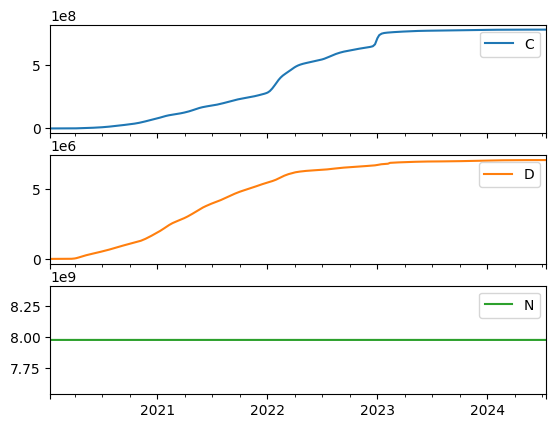

In [5]:
global_data_container.data[["C", "D", "N"]].plot(
    subplots=True
)
plt.show()

The dictionary containing the meaning of every label could be retrieved from the `compartment_labels` attribute from the module itself.

In [6]:
from epydemics import compartment_labels
compartment_labels

{'A': 'Active',
 'C': 'Confirmed',
 'S': 'Susceptible',
 'I': 'Infected',
 'R': 'Recovered',
 'D': 'Deaths'}

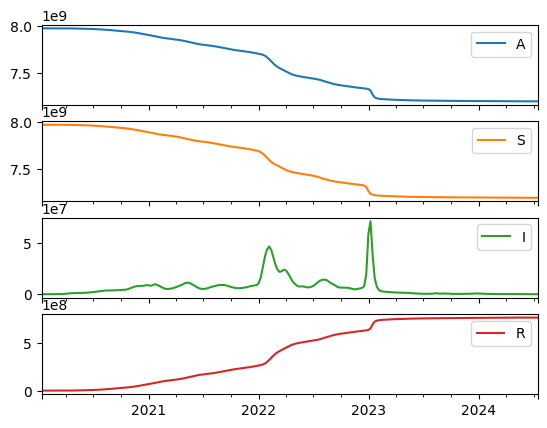

In [7]:
global_data_container.data[["A", "S", "I", "R"]].plot(
    subplots=True
)
plt.show()

As it was stated in the introduction, the non-constant but time-depending nature of the rate is the core of this model.

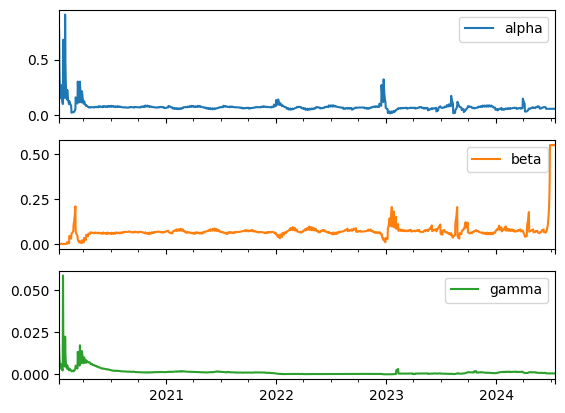

In [8]:
global_data_container.data[["alpha", "beta", "gamma"]].plot(
    subplots=True
)
plt.show()

Create a model using the `global_data_container` object, using information from March 01, 2020, to December 31, 2020.

In [9]:

global_model = Model(
    global_data_container,
    start="2020-03-01",
    stop="2020-12-31",
)


In the following, we apply these methods to create and to a time series model for the logit of the rates $\alpha$, $\beta$ and $\gamma$. This is the core of the model. Please refer to the documentation for more information.

In [10]:
global_model.create_logit_ratios_model()
global_model.fit_logit_ratios_model()

Now that we have a model these rate, we can adjust the numbers of days (`steps`) to forecast. The `forecast_logit_ratios` method returns a Pandas DataFrame object containing the forecasted logit ratios. The `forecasting_interval` attribute contains the forecasting interval.

In [11]:

global_model.forecast_logit_ratios(steps=30)
global_model.forecasting_interval

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30'],
              dtype='datetime64[ns]', freq='D')

Run the simulations and generate the results. The `generate_result` method returns a Pandas DataFrame object `global_model.results` containing the results.

In [12]:

global_model.run_simulations()
global_model.generate_result()


Finally, we can visualize the results. The `visualize_results` method returns a Matplotlib Figure object. At first, create a testing dataset using global data container and the global model forecasting interval. The `global_testing_data` is a Pandas DataFrame object containing the testing data.

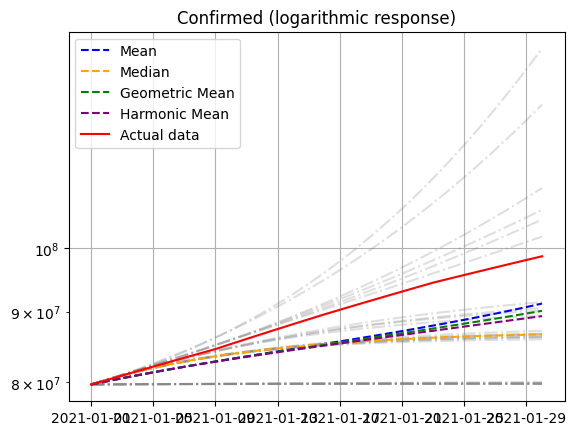

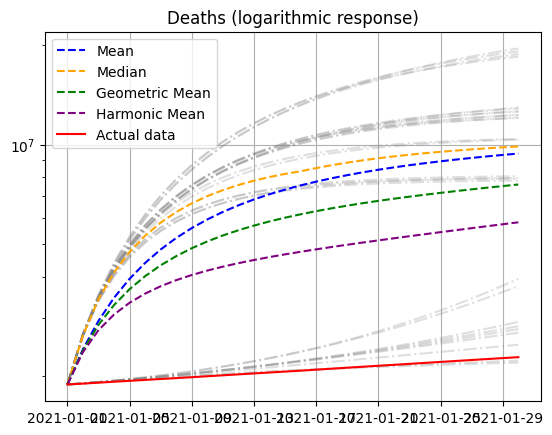

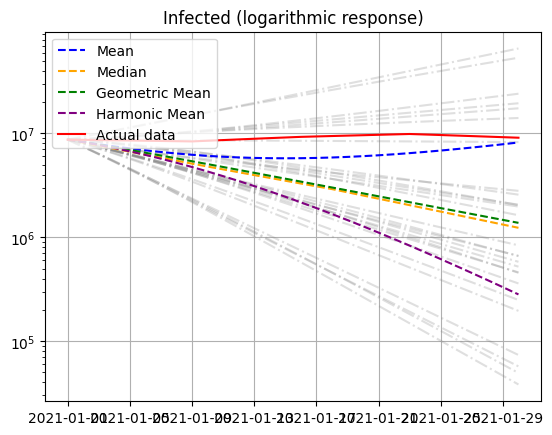

In [13]:

global_testing_data = global_data_container.data.loc[global_model.forecasting_interval]

for compartment in ["C", "D", "I"]:
    global_model.visualize_results(
        compartment,
        global_testing_data,
        log_response=True)

The gray dotted lines are several forecasting depending on the confidence interval for the time series model for the logit of the rates $\alpha$, $\beta$ and $\gamma$. The solid red line is the actual data in the forecasting interval. To make it clearer, we add many methods of central tendency to compare the forecasting with the actual data.

A very peculiar feature of this model is that the forecasting is not a single value but a distribution. For example, although the averages of forecasted deaths are not so close to the actual data, the lower forecasting series are very close to the actual data.

A tool for evaluare forecast in a more rigours manner is provided, using several criteria, and this analysis could be saved for further analysis.

In [14]:
import json
evaluation = global_model.evaluate_forecast(global_testing_data, save_evaluation=True, filename="global_evaluation")

print(json.dumps(evaluation, indent=4))


{
    "C": {
        "mean": {
            "mae": 3953118.1286311145,
            "mse": 21998234877704.82,
            "rmse": 4690227.593380178,
            "mape": 4.26636167776729,
            "smape": 2.1973382462141853
        },
        "median": {
            "mae": 4693655.856369934,
            "mse": 37734082537310.336,
            "rmse": 6142807.382403451,
            "mape": 5.000903294697744,
            "smape": 2.6094838772640307
        },
        "gmean": {
            "mae": 4208892.118494461,
            "mse": 25588740464840.117,
            "rmse": 5058531.453380528,
            "mape": 4.533834571140922,
            "smape": 2.3413907406354793
        },
        "hmean": {
            "mae": 4411551.848708676,
            "mse": 28531647227915.863,
            "rmse": 5341502.3380988855,
            "mape": 4.747350280319226,
            "smape": 2.456677710311852
        }
    },
    "D": {
        "mean": {
            "mae": 4719709.635685853,
            "ms

## Further work
Since this is a very new model, there are many things to do. For example, we could try to use other time series models for the logit of the rates $\alpha$, $\beta$ and $\gamma$. We could also try to use other machine learning models for the forecasting.
The results obtained at this point should be tested and compared in other contexts, for example, by varying the time interval, or by using data for other regions.

## References

**Allen u.a. 2008** Allen, L.J.S. ; Brauer, F. ; Driessche, P. van den ;
 Bauch, C.T. ; Wu, J. ; Castillo-Chavez, C. ; Earn, D. ; Feng, Z. ;
 Lewis, M.A. ; Li, J. u.a.: Mathematical Epidemiology. Springer Berlin
 Heidelberg, 2008 (Lecture Notes in Mathematics).– URL https://books.
 google.com/books?id=gcP5l1a22rQC.– ISBN 9783540789109

**Andrade u.a. 2021** Andrade, Marinho G. ; Achcar, Jorge A. ; Conce
icc˜ ao, Katiane S. ; Ravishanker, Nalini: Time Series Regression Models
 for COVID-19 Deaths. In: J. Data Sci 19 (2021), Nr. 2, S. 269–292

**Hawas 2020** Hawas, Mohamed: Generated time-series prediction data of
 COVID-19s daily infections in Brazil by using recurrent neural networks. In:
 Data in brief 32 (2020), S. 106175

**Maleki u.a. 2020** Maleki, Mohsen ; Mahmoudi, Mohammad R. ; Wraith,
 Darren ; Pho, Kim-Hung: Time series modelling to forecast the confirmed
 and recovered cases of COVID-19. In: Travel medicine and infectious disease
 37 (2020), S. 101742

**Martcheva 2015** Martcheva, M.: An Introduction to Mathematical Epi
demiology. Springer US, 2015 (Texts in Applied Mathematics).– URL https:
 //books.google.com/books?id=tt7HCgAAQBAJ.– ISBN 9781489976123

**Singh u.a. 2020** Singh, Vijander ; Poonia, Ramesh C. ; Kumar, Sandeep ;
 Dass, Pranav ; Agarwal, Pankaj ; Bhatnagar, Vaibhav ; Raja, Linesh:
 Prediction of COVID-19 coronavirus pandemic based on time series data
 using Support Vector Machine. In: Journal of Discrete Mathematical Sciences
 and Cryptography 23 (2020), Nr. 8, S. 1583–1597

**Wacker und Schluter 2020** Wacker, Benjamin; Schluter, Jan: Time
continuous and time-discrete SIR models revisited: theory and applications.
 In: Advances in Difference Equations 2020 (2020), Nr. 1, S. 1–44.– ISSN
 1687-1847.– URL https://doi.org/10.1186/s13662-020-02907-9
